# Implementierung

In [46]:
import numpy as np
import matplotlib.pyplot as plt

from scipy import linalg

## Quadratur-Formel

Exakte Quadratur:

\begin{align*}
    Q(f)
    :=
    \frac{1}{2 \pi i}
    \int_{|\lambda| = R}
    f(\lambda)
    d \lambda
\end{align*}

Approximative Quadrature:

\begin{align*}
    Q_m(f)
    :=
    \frac{R}{m}
    \sum_{\nu=0}^{m-1}
    \omega_m^\nu f(R \omega_m^\nu),
    \quad
    \omega_m
    :=
    \exp
    \left(
        \frac{2 \pi i}{m}
    \right )
\end{align*}

In [47]:
# quadrature node
omega = lambda m: np.exp(2 * np.pi * 1j / m)

# quadrature on 0-centered ball with radius R
Q_zero = lambda m, f, R: R / m * sum([
    omega(m) ** nu * f(R * omega(m) ** nu)
    for nu in range(m)
])

# quadrature on z-centered ball with radius R
Q = lambda m, f, R, z: Q_zero(m, lambda x: f(x + z), R)

## Integralmethode

1. Berechne $A_0 \in \mathbb{C}^{N \times j}$

\begin{align*}
    A_1
    :=
    \frac{1}{2 \pi i}
    \int_\Gamma
    \lambda A(\lambda)^{-1} \hat{V}
    d \lambda
    \in \mathbb{C}^{N \times j}
\end{align*}

2. Berechne reduzierte Singulärwertzerlegung $A_0 = \tilde{V} \Sigma \tilde{W}^\ast$ mit $J$ Singulärwerten

3. Berechne $A_1 \in \mathbb{C}^{N \times j}$

\begin{align*}
    A_1
    :=
    \frac{1}{2 \pi i}
    \int_\Gamma
    \lambda A(\lambda)^{-1} \hat{V}
    d \lambda
    \in \mathbb{C}^{N \times j}
\end{align*}

4. Berechne die Eigenwerte der Matrix $\tilde{V} A_1 \tilde{W} \Sigma^{-1} \in \mathbb{C}^{j \times j}$ (z.B. mit QR-Verfahren)

In [48]:
# the big cheese
def integral_method(A, N, j, m, R, z, tol):

    """
    A ... matrix-function
    N ... number of rows/columns of A(lambda)
    j ... number of expected eigen values in ball B_R(z) ...
    m ... number of quadrature nodes
    R ... ball-radius
    z ... ball-center
    tol ... tolerance for singular value decomposition reduction
    """

    # random matrix
    V_hat = np.random.random((N, j))

    # ------------------------ #
    # step 1: calculate A_0

    # integrand of A_0
    def f_0(lamda):

        LU, piv = linalg.lu_factor(A(lamda))

        return np.array([
            linalg.lu_solve((LU, piv), V_hat[:, i])
            for i in range(j)
        ]).T

    # apply quadrature to integrand for A_0
    A_0 = Q(m, f_0, R, z)

    # ------------------------ #
    # step 2: calculate singular value decomposition with J number of singular values

    # get full i.e. unreduced singular value decomposition
    V_tilde, Sigma, W_tilde = linalg.svd(A_0, full_matrices = False)
    
    Cut = Sigma

    # mask for SVD reduction (kill zero values)
    mask = np.abs(Sigma) > tol

    # apply mask i.e. reduce SVD
    Sigma = Sigma[mask]
    V_tilde = V_tilde[:, mask]
    W_tilde = W_tilde[mask, :]

    # ------------------------ #
    # step 3: calculate A_1

    # integrand of A_1
    f_1 = lambda lamda: lamda * f_0(lamda)

    # apply quadrature to integrand for A_1
    A_1 = Q(m, f_1, R, z)

    # ------------------------ #
    # step 4: calculate eigen values (e.g. via QR-method)

    return linalg.eigvals(V_tilde.conj().T @ A_1 @ W_tilde.conj().T @ np.diag(Sigma ** (-1))), Cut

# Tests

Um die exakten und approximierten Eigenwerte zu plotten, verwenden wir `plot_complex`.

In [116]:
def plot_complex(number_matrix, title = None, legend = None, size = 2):

    fig = plt.figure(figsize = (15, 15))

    for number_array in number_matrix:

        plt.scatter(
            *np.array([
                [number.real, number.imag]
                for number in number_array
            ]).T, s= size
        )

    plt.grid(linestyle = ':')
    plt.xlabel('$\Re$')
    plt.ylabel('$\Im$')

    if title != None:
        plt.suptitle(title)

    if legend != None:
        plt.legend(legend)

    fig.show()

## Konstante Matrix-Funktionen aus ähnlichkeits-tranformierten Diagonalmatrizen

Um die Funktion `integral_method` zu testen, konstruieren wir einfache Matrix-Funktionen.

Die wohl einfachsten Matrix-Funktion sind konstant gleich einer Matrix.
Die Eigenwerte von Diagonalmatrizen stehen direkt in ihrer Diagonale.
Ähnliche Matrizen haben dieselben Eigenwerte.

Wir werden also für gegebene Eigenwerte `eigen_values` eine Diagonalmatrix `diagonal_matrix` erstellen und diese mit irgendeiner regulären Matrix `T` bzw. ihrer Inversen `T.inv()` von links und rechts multiplizieren.
Die dadurch entstandene Matrix `A_const` hat also die Eigenwerte `eigen_values`.
Jetzt müssen wir `A_const` nur noch zu einer konstanten Funktion `A` machen.

In [50]:
# ---------------------------------------------------------------- #

def test_1_matrix(eigen_values):

    # diagonal matrix with eigen values in diagonal
    diagonal_matrix = np.diag(eigen_values)

    # transformation matrix
    T = np.random.random(diagonal_matrix.shape)

    # arbitrary matrix with known eigen values
    A = T @ diagonal_matrix @ linalg.inv(T)

    # function A
    A = lambda lamda: T @ diagonal_matrix @ linalg.inv(T) - lamda * np.eye(N)

    return A

# ---------------------------------------------------------------- #

def test_1_get_error_array(eigen_values_exact, N, j, m_array, R, z, tol):

    # get dummy matrix from given exact eigen values
    A = test_1_matrix(eigen_values_exact)

    error_array = []

    for m in m_array:

        # apply integral method
        eigen_values_approx, Cut = integral_method(A, N, j, m, R, z, tol)

        # calculate maximum error of eigen value approximation
        error = max([
            min([
                np.abs(approx - exact)
                for exact in eigen_values_exact
            ])
            for approx in eigen_values_approx
        ])

        # append error to array
        error_array.append(error)

    return error_array

# ---------------------------------------------------------------- #

def test_1_plot_error_array(m_array, error_array, reference_order):

    s = reference_order
    reference_label = 'reference:' + ' ' + r'$\mathcal{O}(m^{{{-' + str(s) + r'}}})$'

    fig = plt.figure(figsize = (15, 10))

    plt.loglog(m_array, error_array,      label = 'approximation error')
    plt.loglog(m_array, 1 / m_array ** s, label = reference_label)

    plt.legend()
    plt.xlabel('$m$')
    plt.grid(linestyle = ':')

    fig.show()

# ---------------------------------------------------------------- #

### Einzelne Werte

<ipython-input-49-65c190d5c394>:24: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


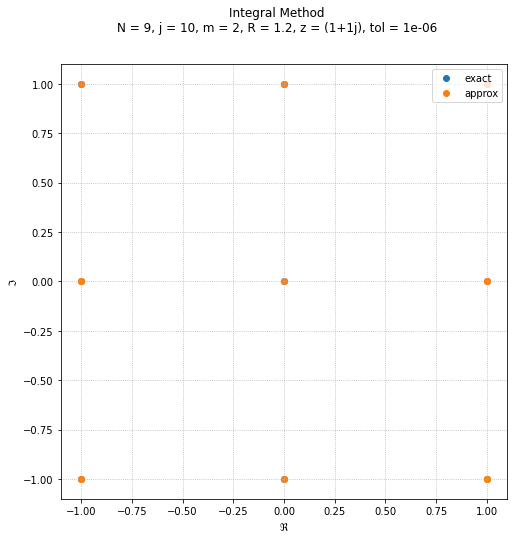

In [51]:
eigen_values_exact = [1 + 1j, 1 - 1j, -1 + 1j, -1 - 1j, 0, 1, 1j, -1j, -1]

A = test_1_matrix(eigen_values_exact)
N = len(eigen_values_exact)
j = 10
m = 2
R = 1.2
z = 1 + 1j
tol = 1e-6

eigen_values_approx, Cut = integral_method(A, N, j, m, R, z, tol)

title = 'Integral Method' + '\n' + f'N = {N}, j = {j}, m = {m}, R = {R}, z = {z}, tol = {tol}'
legend = ('exact', 'approx')

plot_complex([eigen_values_exact, eigen_values_approx], title, legend)

### Konvergenz-Plot

In [52]:
eigen_values_exact = [1 + 1j, 1 - 1j, -1 + 1j, -1 - 1j, 0, 1, 1j, -1j, -1]

N = len(eigen_values_exact)
j = 4
m_array = np.array([2, 3, 4, 5, 10, 20, 50, 100, 1000])
R = 1.5
z = 1 + 1j
tol = 1e-6

error_array = test_1_get_error_array(eigen_values_exact, N, j, m_array, R, z, tol)

<ipython-input-50-e7264d3d3ca4>:63: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


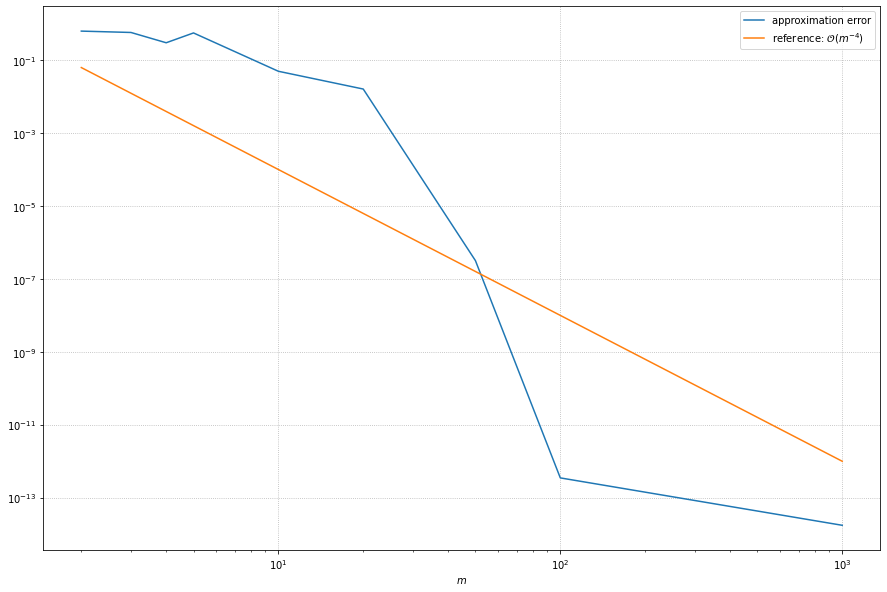

In [53]:
reference_order = 4
test_1_plot_error_array(m_array, error_array, reference_order)

## Hadeler Problem

\begin{gather}
    T(z) = (e^z - 1) B_1 + z^2 B_2 - B_0 \\
    B_0 = b_0 I, \quad B_1 = (b_{jk}^{(1)}), \quad B_2 = (b_{jk}^{(2)}) \\
    b_{jk}^{(1)} = (n + 1 - \max(j, k)) j k, \quad b_{jk}^{(2)} = n \delta_{jk} + 1 / (j + k)
\end{gather}

In [54]:
def test_2_matrix(n, b_0):

    b_1 = lambda j, k: (n + 1 - max(j, k)) * j * k
    b_2 = lambda j, k: n * int(j == k) + 1 / (j + k)

    B_0 = b_0 * np.eye(n)
    B_1 = np.array([[b_1(j+1, k+1) for k in range(n)] for j in range(n)])
    B_2 = np.array([[b_2(j+1, k+1) for k in range(n)] for j in range(n)])

    T = lambda z: (np.exp(z) - 1) * B_1 + z ** 2 * B_2 - B_0

    return T

# Referenzwerte

In [108]:
n = 200
b_0 = 100

T = test_2_matrix(n, b_0)
N = n
j = 20
m = 200
R = 11.5
z = -30
tol = 1e-6

quadrature_nodes = [R * (omega(m) ** nu) + z for nu in range(m)]

eigen_values_approx, Cut = integral_method(T, N, j, m, R, z, tol)

eigen_values_fake, Cut = integral_method(T, N, j, m, R, z, 0)

print(Cut)

[5.11154509e-04 2.34216387e-04 2.19100444e-04 1.93761382e-04
 1.63523308e-04 1.39263813e-04 1.06485865e-04 9.71928731e-05
 7.63440134e-05 6.80312336e-05 6.51790726e-05 5.31452952e-05
 3.97167045e-05 1.90006303e-05 1.41665348e-08 4.77251604e-13
 5.92486652e-15 1.62947356e-17 1.73921253e-18 1.44204167e-18]


<ipython-input-116-04b50c0ecb9f>:24: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


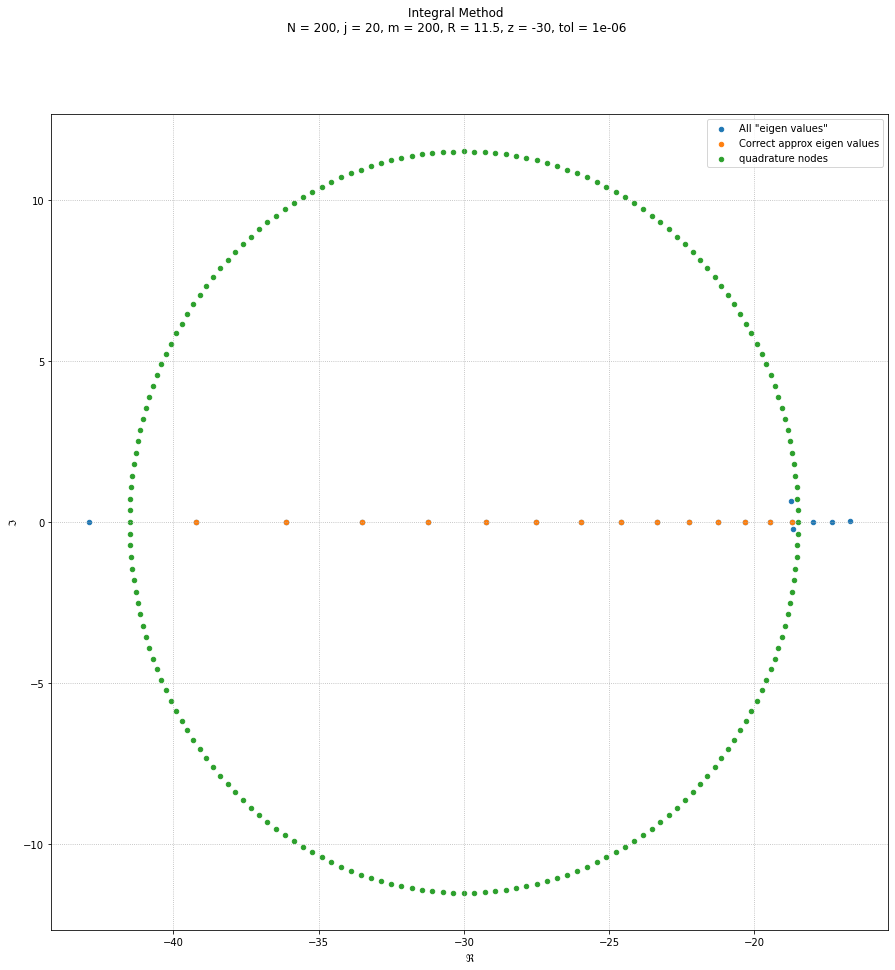

In [117]:
title = 'Integral Method' + '\n' + f'N = {N}, j = {j}, m = {m}, R = {R}, z = {z}, tol = {tol}'
legend = ('All "eigen values"', 'Correct approx eigen values', 'quadrature nodes')

plot_complex([eigen_values_fake, eigen_values_approx, quadrature_nodes], title, legend,20)


In [65]:

print(eigen_values_approx)
eigen_value_refs = []

for eigen_value in eigen_values_approx:
    N = n
    j = 1
    m = 50
    R = 0.1
    tol = 1e-6
    eigen_value_ref,_ = integral_method(T, N, j, m, R, eigen_value, tol)
    eigen_value_refs.append(eigen_value_ref[0])


[-39.21900548+6.11787588e-15j -36.13349266+1.22398034e-14j
 -33.5010599 +3.17728060e-14j -31.22956362-4.72440180e-15j
 -29.2461255 -5.24503395e-15j -27.50786339-3.00953844e-15j
 -18.7089098 -7.07818302e-15j -19.48001136-1.48321361e-14j
 -20.32024348+1.61405088e-14j -25.96965457+4.39731598e-15j
 -24.59472978+1.22296869e-14j -21.2390153 -1.95656588e-14j
 -22.2481887 +3.86877091e-14j -23.36094351+9.74575596e-15j]
(-39.22119716420388-2.3837765430502786e-16j)
(-36.13367281537617-4.236680979861166e-17j)
(-33.501504538197004-4.10419937346884e-16j)
(-31.229992916308365-3.3194655155527747e-16j)
(-29.250999644306965-2.6090855677191846e-16j)
(-27.510852621820728-9.102354834662043e-16j)
(-18.708911064458178+7.418379917045466e-15j)
(-19.48008877525587+3.8852443010793347e-16j)
(-20.32024347608116+1.7376029902963754e-16j)
(-25.969671424868903+1.6175796610164467e-15j)
(-24.594773687204302-2.526185488181452e-16j)
(-21.239257884477563+1.5150357706352954e-15j)
(-22.24822482382236+1.9151643708190263e-15j)

<ipython-input-49-65c190d5c394>:24: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


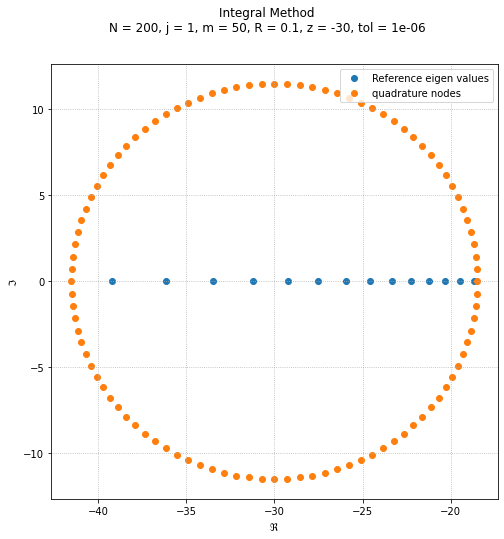

In [68]:
title = 'Integral Method' + '\n' + f'N = {N}, j = {j}, m = {m}, R = {R}, z = {z}, tol = {tol}'
legend = ('Reference eigen values', 'quadrature nodes')

plot_complex([eigen_value_refs, quadrature_nodes], title, legend)


In [94]:
error_array_array = []
m_array = [5,10,15,20,50,100]
R_array = [9.5,10.5,11.5]


for R in R_array:
    error_array = []
    for m in m_array:
        N = n
        j = 15
        z = -30
        tol = 1e-6
        eigen_values_approx,_ = integral_method(T, N, j, m, R, z, tol)

        error_array.append(max([
                min([
                    np.abs(approx - ref)
                    for ref in eigen_value_refs
                ])
                for approx in eigen_values_approx
            ]))
    error_array_array.append(error_array)
    
    

[4.1583399678866915, 0.7286008891890567, 0.964486101812355, 1.015107699395081, 0.7092166627129011, 0.03044303776857049]


<ipython-input-95-29452b3188d6>:6: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


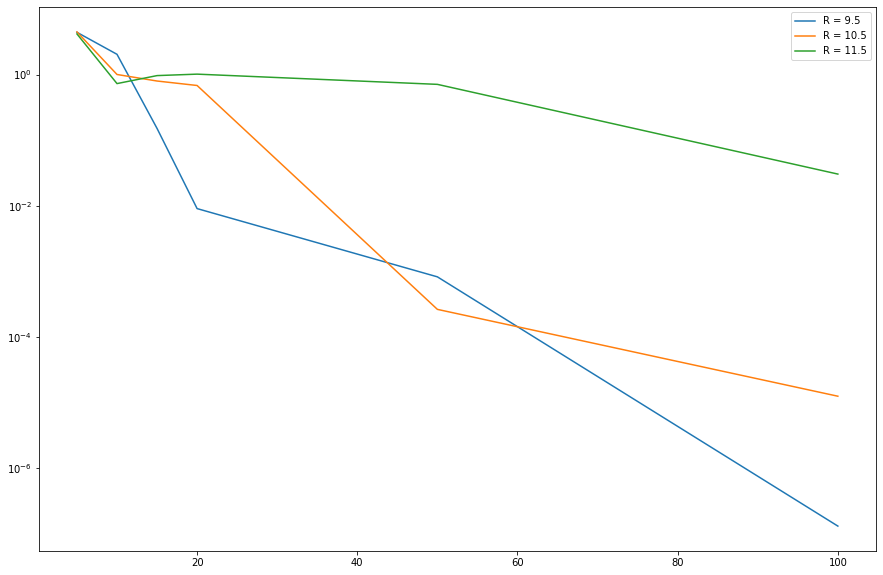

In [95]:
print(error_array)
fig = plt.figure(figsize = (15, 10))
for error_array, R in zip(error_array_array,R_array):
    plt.semilogy(m_array,error_array, label = "R = {}".format(R))
plt.legend()
fig.show()

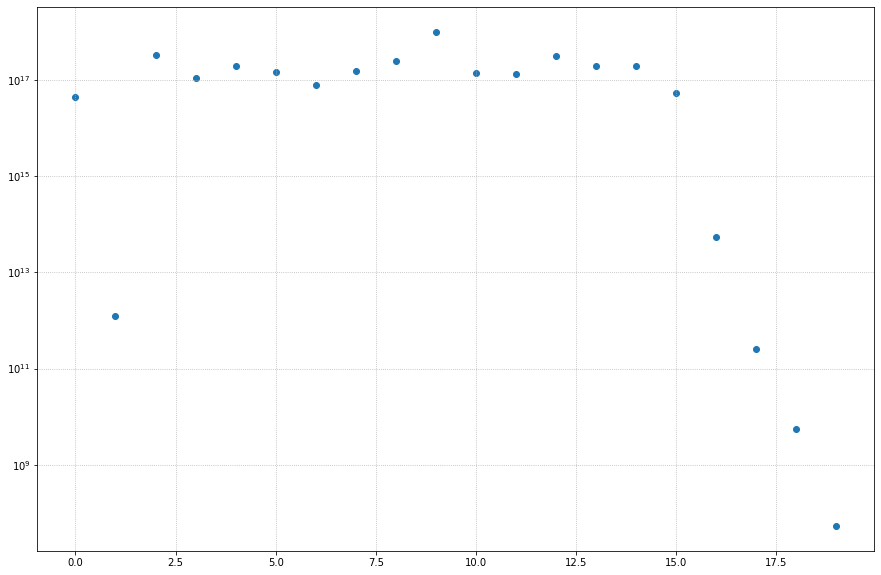

In [103]:

cond_list = [np.linalg.cond(T(ref)) for ref in eigen_values_fake]
fig = plt.figure(figsize = (15, 10))
ax = fig.gca()
ax.scatter(range(len(cond_list)),cond_list)
ax.grid(linestyle = ":")
ax.set_yscale('log')
